#**Import Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from wordcloud import WordCloud

# **Load The Datasets** **And Basic Data Exploration**

In [ ]:
train_data = pd.read_excel("/content/Symptom Classification dataset - 2 -- Train.xlsx")
val_data = pd.read_excel("/content/Symptom Classification dataset - 2 -- Val.xlsx")
test_data = pd.read_excel("/content/Symptom Classification dataset - 2 -- Test.xlsx")

# Display the first few rows of each dataset
train_data.head(), val_data.head(), test_data.head(), train_data.shape, val_data.shape, test_data.shape


(                                                text  labs partition
 0  Sally is around the same age, 25 I assume, (ca...     0     Train
 1  Every once and a while I will get this over wh...     1     Train
 2  Then about 25 minutes later I got a message fr...     0     Train
 3  However, today I was sitting at work and for w...     1     Train
 4  I was nice, and it got me no where, so I was r...     1     Train,
                                                 text  labs partition
 0  She never messaged him back, but I asked her w...     0       Val
 1  Dear reddit, For what I am about to tell you t...     1       Val
 2  I won't defend myself, I know I shouldn't have...     1       Val
 3  also this week I posted about being excited ab...     0       Val
 4  He admitted to me that night that yes, she nee...     0       Val,
                                                 text  labs partition
 0  I blocked him on FB and then deactivated. One ...   NaN      Test
 1  -I'm not doing

# **EDA - Distribution of labels and basic text statistics**

<ipython-input-3-ccfc81e99c91>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labs', data=train_data, palette='viridis')


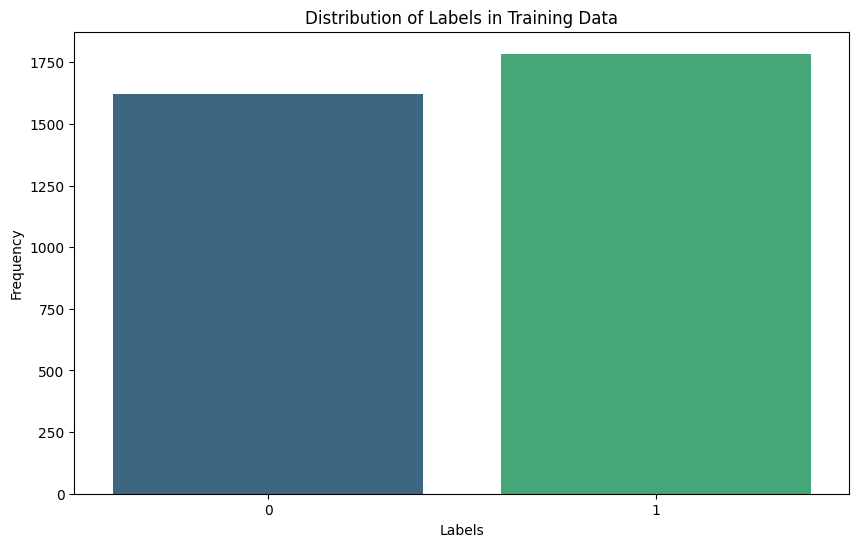

,word_count,unique_words,char_count
count,3405.000000,3405.000000,3405.000000
mean,85.350661,64.582085,446.198532
std,31.699313,19.381781,166.346662
min,1.000000,1.000000,6.000000
25%,65.000000,53.000000,339.000000
50%,80.000000,62.000000,418.000000
75%,100.000000,75.000000,522.000000
max,310.000000,194.000000,1639.000000


In [ ]:
# Plot the distribution of labels in the training data
plt.figure(figsize=(10, 6))
sns.countplot(x='labs', data=train_data, palette='viridis')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# Basic text statistics: number of words, unique words, and characters
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['unique_words'] = train_data['text'].apply(lambda x: len(set(x.split())))
train_data['char_count'] = train_data['text'].apply(lambda x: len(x))

# Display summary statistics
train_data[['word_count', 'unique_words', 'char_count']].describe()


# **Topic Modeling with LDA**

In [ ]:
# Initialize CountVectorizer
count_vect = CountVectorizer(max_df=0.95, min_df=2, max_features=5000, stop_words='english')

# Apply CountVectorizer to the training data
X_train_counts = count_vect.fit_transform(train_data['clean_text'])

# Initialize LDA model:
lda = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch')

# Fit the LDA model
lda.fit(X_train_counts)

# Display topics and the associated words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, count_vect.get_feature_names_out(), 10)


Topic 0:
im just like dont time really know job got help
Topic 1:
help people url know im need thank family like dont
Topic 2:
im like feel dont just know want really ive things
Topic 3:
just ive im anxiety time like life going day years
Topic 4:
time told years didnt said just like got friend know


Generate and display Word Clouds for each topic

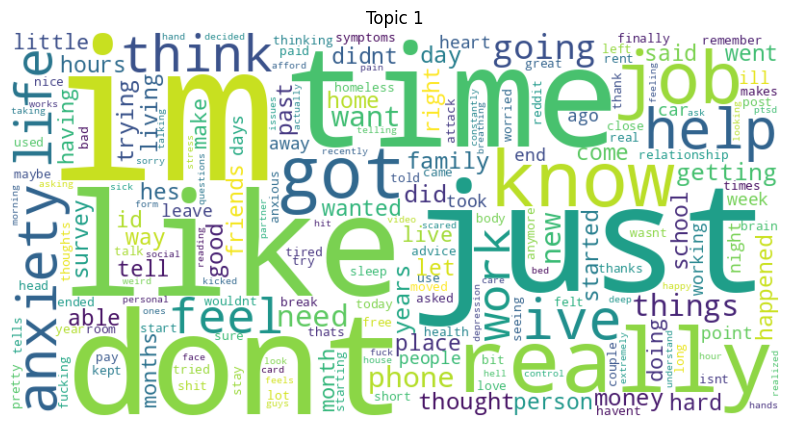

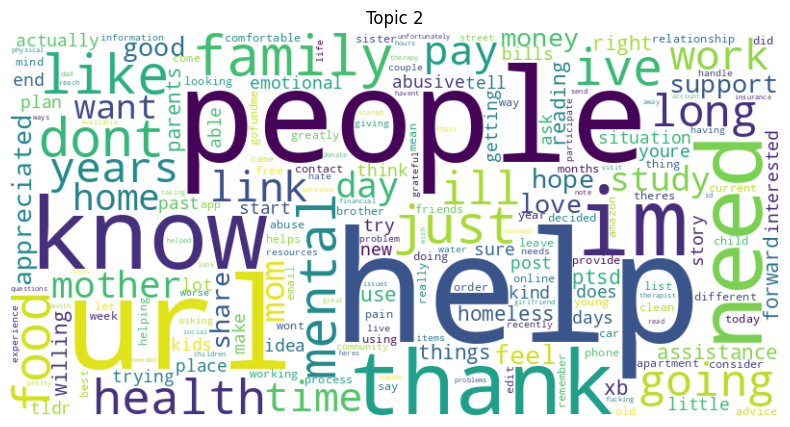

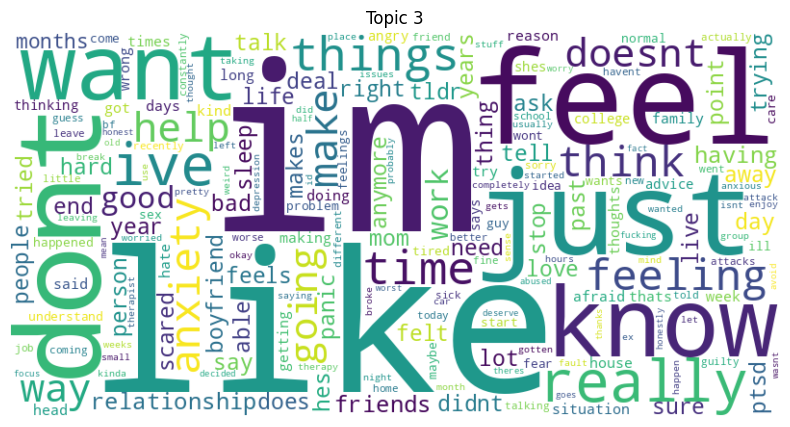

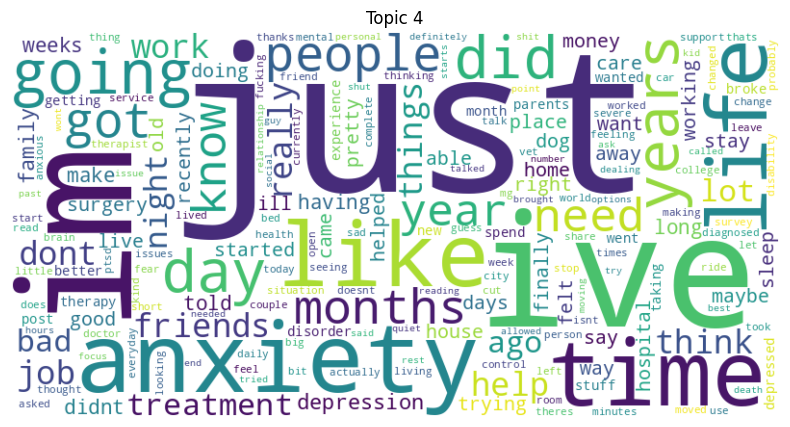

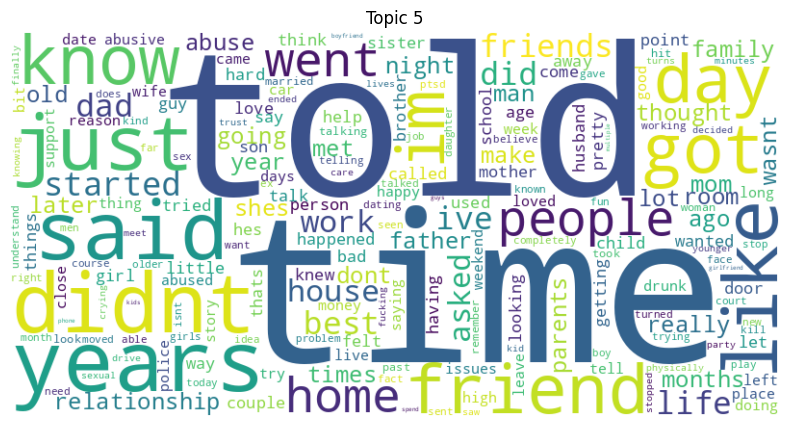

In [ ]:
# Generate Word Clouds for each topic
def generate_word_clouds(model, feature_names, num_topics):
    for topic_idx in range(num_topics):
        topic_words = {feature_names[i]: model.components_[topic_idx, i] for i in range(len(feature_names))}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx + 1}')
        plt.axis("off")
        plt.show()

generate_word_clouds(lda, count_vect.get_feature_names_out(), 5)


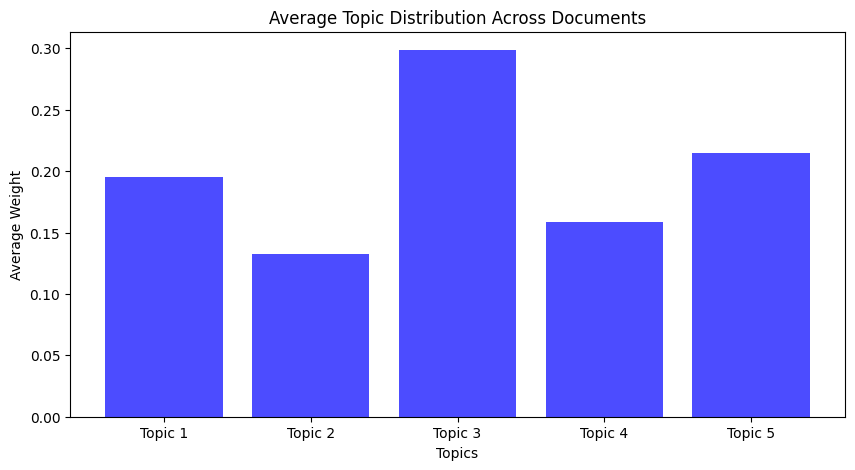

In [ ]:
# Get the topic distribution for each document
topic_distribution = lda.transform(X_train_counts)

# Average topic weights across all documents
average_topic_weights = np.mean(topic_distribution, axis=0)

# Plot the topic distribution
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), average_topic_weights, color='blue', alpha=0.7)
plt.title('Average Topic Distribution Across Documents')
plt.xlabel('Topics')
plt.ylabel('Average Weight')
plt.xticks(range(1, 6), [f'Topic {i}' for i in range(1, 6)])
plt.show()


# **Preprocessing Text Data**

In [ ]:
def simplified_clean_text(text):
    # Convert to lower case
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text, re.I|re.A)
    return text

# Clean the text in the datasets without removing stopwords
train_data['clean_text'] = train_data['text'].apply(simplified_clean_text)
val_data['clean_text'] = val_data['text'].apply(simplified_clean_text)
test_data['clean_text'] = test_data['text'].apply(simplified_clean_text)

# Reinitialize TF-IDF Vectorizer and re-transform the data
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_data['clean_text'])
X_val_tfidf = tfidf.transform(val_data['clean_text'])
X_test_tfidf = tfidf.transform(test_data['clean_text'])

# Encoding the labels again
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['labs'])
y_val = label_encoder.transform(val_data['labs'])

X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape

# Save the preprocessed data to Excel files
output_train_path = "Preprocessed_Train.xlsx"
output_val_path = "Preprocessed_Val.xlsx"
output_test_path = "Preprocessed_Test.xlsx"

train_data.to_excel(output_train_path, index=False)
val_data.to_excel(output_val_path, index=False)
test_data.to_excel(output_test_path, index=False)

output_train_path, output_val_path, output_test_path


('Preprocessed_Train.xlsx', 'Preprocessed_Val.xlsx', 'Preprocessed_Test.xlsx')

# **Modeling with Random Forest**

In [ ]:
# Initialize models
random_forest = RandomForestClassifier(random_state=42)

# Train and evaluate Random Forest
random_forest.fit(X_train_tfidf, y_train)
val_pred_rf = random_forest.predict(X_val_tfidf)
accuracy_rf = accuracy_score(y_val, val_pred_rf)


accuracy_rf


0.892511013215859

Prediction and Output

In [ ]:
# Predict using the Random Forest model on the test data
test_pred_rf = random_forest.predict(X_test_tfidf)

test_pred_rf[:10]

# Create a DataFrame for test predictions
test_predictions_df = pd.DataFrame({
    'text': test_data['text'],
    'predicted_label': test_pred_rf
})

output_test_predictions_path = "Test_Predictions.xlsx"
test_predictions_df.to_excel(output_test_predictions_path, index=False)

output_test_predictions_path


'Test_Predictions.xlsx'

Performance Metrics

In [ ]:
# Calculate macro-average recall for the training predictions
macro_recall_train = recall_score(y_train, train_pred_rf, average='macro')

# Calculate macro-average recall for the validation predictions
macro_recall_val = recall_score(y_val, val_pred_rf, average='macro')

# Output the recall scores
print("Macro-average Recall on Training Data: {:.3f}".format(macro_recall_train))
print("Macro-average Recall on Validation Data: {:.3f}".format(macro_recall_val))

Macro-average Recall on Training Data: 0.999
Macro-average Recall on Validation Data: 0.891
